In [3]:
#
# phase2 :
#   Banana model inference
#
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
import network
import network.normFlow as nf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import models.mars as mars
import seaborn as sns
DIM = 2
SAMPLINGNUM = 20
floatX = utils.floatX

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [5]:
LOW,HIGH = -4,+4

In [6]:
# constructing graphical model
ROOT = '../report/figs/inference/'
MODEL_NAME = 'apple'
OUTPATH = ROOT + '/'+MODEL_NAME

# energy based model
model = mars.Apple()

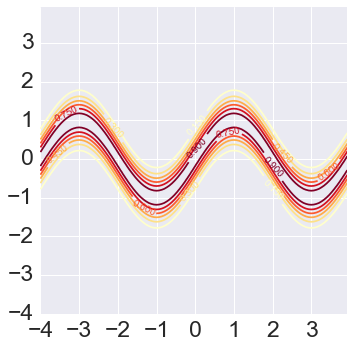

In [12]:
# plot true posterior
GAP = ( HIGH - LOW )/120.
gz, g1, g2 = mathZ.gridPoints( (LOW,HIGH,GAP), (LOW,HIGH,GAP) )
# bnn
gpz = np.exp( model.nlogPz( gz ).reshape(g1.shape[1],g2.shape[0]) )

fig = plt.figure()
CS = plt.contour(g1,g2,gpz,cmap='YlOrRd')
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
plt.tick_params(axis='both', which='major', labelsize=23)
plt.savefig(OUTPATH+'/%s.png'%(MODEL_NAME))
plt.show()



In [42]:
NUM_LAYERS = 8
# NF_TYPE, STD = 'uniform', 3
NF_TYPE, STD = 'normal', 1.5

In [43]:
# construction variational model
iaf = nf.NormFlowModel( dim=DIM, numlayers=NUM_LAYERS,noisestd=STD,z0type=NF_TYPE )  #(4./DIM)**.5
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)

# setting cost variable
logpxz,_,_ = model.logPxz(z)
cost = T.mean( logqz - logpxz )  # negative-ELBO

params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [44]:
# optimisation setup
iaf.reInit()
opt = optimizers.SGD(params,lr=0.05,momentum=0.5,decay=0.001)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpxz), T.mean(logqz) ]
# apple
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [45]:
# for presentation
e2 = iaf.getNoiseVar(50000)
z2, logqz2 = iaf.reparam(e2)
fez2 = theano.function(inputs=[],outputs=[e2,z2])

In [46]:
# training
NUMITER = 10000
keys = ['cost','pxz','qz']
record = {}
valx = 2.

# mb.setStd(0.7)
for k in keys:
    record[k] = []
for i in range(NUMITER):
    # apple
    out = estep()
    for i,q in enumerate(out):
        record[keys[i]].append( q )        
for k in keys:
    record[k] = np.asarray( record[k] )

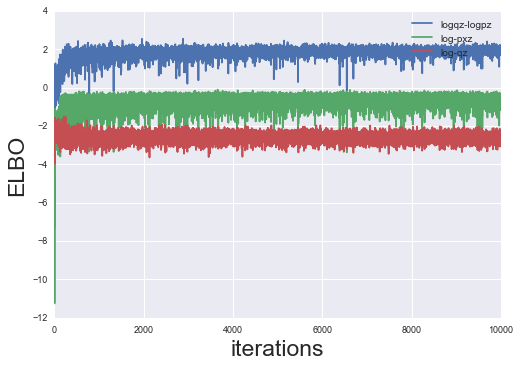

In [47]:
# plt.plot( range(NUMITER), record['cost'],'-' )
# plt.show()
xs = range(NUMITER)
plt.plot( xs, -record['cost'], '-', label='logqz-logpz')
plt.xlabel('iterations',fontsize=23)
plt.ylabel('ELBO',fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig(OUTPATH+'/elbo_L%d_x%d.png'%(NUM_LAYERS,valx))
plt.plot( xs, record['pxz'], '-', label='log-pxz')
plt.plot( xs, record['qz'], '-', label='log-qz')
plt.legend()
plt.show()

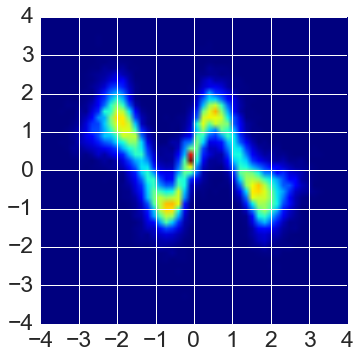

In [48]:
# estimated posterior
es, zs = fez2()
heatmap, xedges, yedges = np.histogram2d( zs[:,0], zs[:,1], bins=50)
extent = [LOW, HIGH, LOW,HIGH]

plt.imshow(heatmap.T, extent=extent, origin='lower',cmap='jet')
plt.xlim(xlims)
plt.ylim(ylims)
plt.tick_params(axis='both', which='major', labelsize=23)
# apple
plt.savefig( OUTPATH+'/qz_L%d_%s.png'%(NUM_LAYERS,NF_TYPE))

In [49]:
###
### SAVE
###
SAVEPATH = (OUTPATH +'/record_x%d_%s.npz')%(valx,NF_TYPE)
np.savez(SAVEPATH, cost=record['cost'], zs=zs, numiters=NUMITER, numlayers=NUM_LAYERS, std=STD, x = valx )
print 'record saved to %s' % SAVEPATH

record saved to ../report/figs/inference//apple/record_x2_normal.npz
